In [2]:
# do the installations
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 57 kB 310 kB/s eta 0:00:01
     |████████████████████████████████| 547 kB 826 kB/s eta 0:00:01
     |████████████████████████████████| 19.3 MB 307 kB/s eta 0:00:01
Using legacy setup.py install for bokeh, since package 'wheel' is not installed.
    Running setup.py install for bokeh ... done
Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install scikit-learn

     |████████████████████████████████| 6.8 MB 809 kB/s eta 0:00:011
     |████████████████████████████████| 300 kB 5.7 MB/s eta 0:00:01


In [4]:
!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 127.3 MB 148 kB/s eta 0:00:01    |███▍                            | 13.4 MB 3.0 MB/s eta 0:00:38     |███▍                            | 13.6 MB 3.0 MB/s eta 0:00:38     |███████████▍                    | 45.1 MB 4.0 MB/s eta 0:00:21     |█████████████████▊              | 70.7 MB 3.6 MB/s eta 0:00:16     |█████████████████████▊          | 86.3 MB 2.9 MB/s eta 0:00:15     |██████████████████████          | 87.1 MB 2.9 MB/s eta 0:00:14     |████████████████████████████▏   | 112.2 MB 2.8 MB/s eta 0:00:06
     |████████████████████████████████| 5.7 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 389 kB/s eta 0:00:01
Using legacy setup.py install for future, since package 'wheel' is not installed.
    Running setup.py install for future ... done


In [6]:
#Use torchvision.datasets.CIFAR10 to load the CIFAR10 dataset
cifar10_train = CIFAR10("./", download=True, train=True)
cifar10_test = CIFAR10("./", download=True, train=False)

NameError: name 'CIFAR10' is not defined

In [1]:
#do the standard imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
import matplotlib.pyplot as plt

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ## uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
    torch.backends.cudnn.enabled   = False  ## does not enable the inbuilt cudnn deep learning library for training neural networks

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available(): ## run on GPUs if available
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
#Use torchvision.datasets.CIFAR10 to load the CIFAR10 dataset
cifar10_train = CIFAR10("./", download=True, train=True)
cifar10_test = CIFAR10("./", download=True, train=False)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(cifar10_train.data, cifar10_train.targets)
#getting the indeces from the shuffle split
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
#normalisation will be applied per channel basis
#It has to be the training set and not the whole dataset, otherwise we would leak 
#information from the test and validate sets to the training
#we first need to find the mean and std of the training set for each channel
means_train = cifar10_train.data[indices[0]].mean(axis=(1,2,0))
std_train = cifar10_train.data[indices[0]].std(axis=(1,2,0))

def apply_normalization(X):
    """
    Vectorised function that normalised the image
    Recieves collection of 3channel images in the train, valid and test sets
    and substracts the mean and devides by the std of the channels in the train set
    """
    normed = (X-means_train)/std_train
    return normed

No GPU available!
Files already downloaded and verified
Files already downloaded and verified


In [14]:
#convert the dataset to a torch tensor
X_train = torch.tensor(cifar10_train.data).float()
#take only the first 50 images 
#and reshape to batchsize, channels, height, width
small_tensor = X_train[0:50,:].transpose(3,1).transpose(2,3)
#confirm
small_tensor.shape

torch.Size([50, 3, 32, 32])

In [15]:
single_image = small_tensor[0]
single_image.shape

torch.Size([3, 32, 32])

In [ ]:
filter1 = 

----------------------------------------------------------------------

In [5]:
normed1 = apply_normalization(cifar10_train.data[indices[0]])
# very simple test to confirm that the normalisation worked 
#- check if the means and stds are 0 and 1 for all channels of the train set 
#after the normalisation
np.allclose(normed1.mean(axis=(1,2,0)), [0.,0.,0.,])
np.allclose(normed1.std(axis=(1,2,0)), [1.,1.,1.,])

True

In [3]:
#normalise using the vectorised function. Using astype to make it more accurate substraction, devision
X_train = apply_normalization(cifar10_train.data[indices[0]].astype(np.float32))

In [4]:
#convert to torch tensor. the model bellow expects them as floats so we have to .float()
X_train = torch.tensor(X_train).float()
#convert the label encodings to tensor
y_train = torch.tensor(cifar10_train.targets)[indices[0]]
#normalise using the vectorised function. Using astype to make it more accurate substraction, devision
X_val = apply_normalization(cifar10_train.data[indices[1]].astype(np.float32))
#convert to torch tensor. the model bellow expects them as floats so we have to .float()
X_val = torch.tensor(X_val).float()
#convert the label encodings to tensor
y_val = torch.tensor(cifar10_train.targets)[indices[1]]
#normalise using the vectorised function. Using astype to make it more accurate substraction, devision
X_test =  apply_normalization(cifar10_test.data.astype(np.float32))
#convert to torch tensor. the model bellow expects them as floats so we have to .float()
X_test = torch.tensor(X_test).float()
#convert the label encodings to tensor 
y_test = torch.tensor(cifar10_test.targets).float()
#Instantiate the datasets
# The transpose here is reshaping the tensor to (channel_number, width, length) = [3,32,32]
#we have to do this because this is the form expected - we get a huge increase in accuracy
#this step wans't needed in for the MNIST and FashionMNIST
cifar10_train_ds = TensorDataset(X_train.transpose(3,1).transpose(2,3), y_train.long())
cifar10_validate_ds = TensorDataset(X_val.transpose(3,1).transpose(2,3), y_val.long())
cifar10_test_ds = TensorDataset(X_test.transpose(3,1).transpose(2,3), y_test.long())
# set the batch size for train and test. These are hyperparameters
batch_size = 64
test_batch_size = 1000
#Instantiate the dataloader
train_loader = DataLoader(cifar10_train_ds, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 implies that the main process should retrieve the data. If num_workers=2 for example, 2 other workers will put data into the RAM instead of the main process.
validation_loader = DataLoader(cifar10_validate_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(cifar10_test_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [5]:
#the only thing we modify here is the input size of the first layer
# to reflect the 3 channels
#create the model class
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    #first argument is in_channels, we have 3 because our image is RGB
    #also remove padding
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
  
x = torch.randn((1, 3, 32, 32))
model = LeNet5()
y = model(x)
print(y)

tensor([[ 0.1351,  0.0598,  0.0142, -0.0843,  0.0009, -0.0679, -0.1216,  0.0752,
         -0.0696,  0.0802]], grad_fn=<AddmmBackward>)


In [6]:
c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
output = c1(X_val)

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[5000, 32, 32, 3] to have 3 channels, but got 32 channels instead

- weight innit

In [13]:
#Python Imaging Library
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [14]:
"""
Import the image, and convert it to 2D array
"""
image_path = "./rsm.jpg"
img_raw = Image.open(image_path)

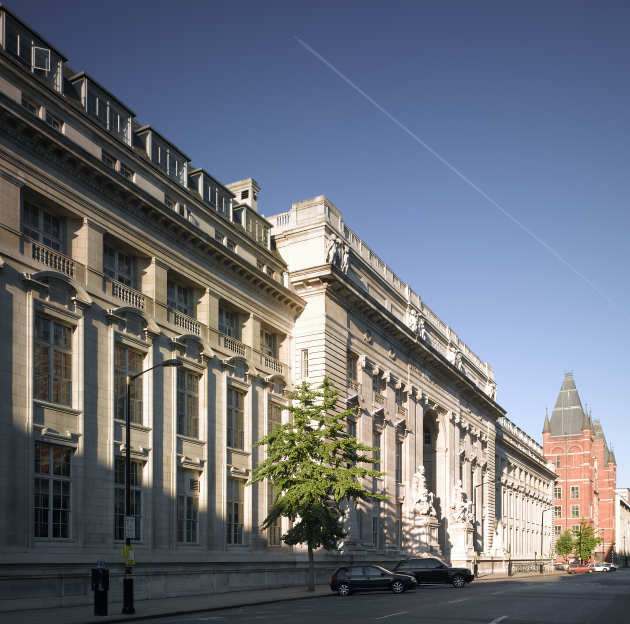

In [15]:
img_raw

In [21]:
(cifar10_train.data[0]).shape
#we expect the data in the form (channels, size, size)

(32, 32, 3)

In [31]:
frog = (cifar10_train.data[0]).reshape(3, 32, 32)
frog.shape

(3, 32, 32)

In [37]:
tensor_frog = torch.tensor(frog).float()
tensor_frog.type

<function Tensor.type>

In [38]:
output = m(tensor_frog)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 3, 5, 5], but got 3-dimensional input of size [3, 32, 32] instead

In [40]:
#Devito
from devito import Function, Operator, Eq, Grid, dimensions
from devito import set_log_level
set_log_level('PERF')
SOBEL_VERTICAL = [[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]]


def get_function(name, matrix=None, shape=None, dimensions=None,
                 space_order=1):
    if matrix is None and shape is None:
        raise Exception("Either matrix or shape must be provided")

    if matrix is not None:
        shape = (len(matrix), len(matrix[0]))

    if dimensions is None:
        grid = Grid(shape=shape)
    else:
        grid = Grid(shape=shape, dimensions=dimensions)

    function = Function(name=name, grid=grid, space_order=space_order)

    if matrix is not None:
        function.data[:] = matrix

    return function


def error_check(kernel, image):
    if kernel is None or len(kernel) == 0:
        raise Exception("kernel must not be empty")

    if image is None or len(image) == 0:
        raise Exception("image must not be empty")

    different_row_length = False
    for row in kernel:
        if len(row) != len(kernel[0]):
            different_row_length = True
            break

    if different_row_length:
        raise Exception("kernel has an invalid shape")

    different_row_length = False
    for row in image:
        if len(row) != len(image[0]):
            different_row_length = True
            break

    if different_row_length:
        raise Exception("image has an invalid shape")

    if len(kernel) % 2 == 0 or len(kernel[0]) % 2 == 0:
        raise Exception("The dimensions of kernel must be odd")


def run(kernel, image):
    # It is assumed that both kernel and image have only two dimensions.

    error_check(kernel, image)

    A = get_function(name='A', matrix=kernel,
                     dimensions=dimensions('m n'), space_order=0)
    B = get_function(name='B', matrix=image, space_order=1)
    R = get_function(name='R', shape=B.shape, space_order=0)

    x, y = B.dimensions
    kernel_rows, kernel_cols = A.shape
    op = Operator(Eq(R[x,y],
                     sum([A[kernel_rows - i - 1,
                            kernel_cols - j - 1] *
                          B[x - kernel_rows // 2 + i,
                            y - kernel_cols // 2 + j]
                          for i in range(kernel_rows)
                          for j in range(kernel_cols)])))

    op.apply()
    return R.data





Operator `Kernel` generated in 0.21 s
  * lowering.IET: 0.13 s (62.7 %)
     * specializing.IET: 0.08 s (38.6 %)
  * lowering.Expressions: 0.05 s (24.1 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/8f9d8725a145adace0c3cfb447643168108e4130.c` in 0.18 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 2}
Operator `Kernel` generated in 0.24 s
  * lowering.IET: 0.16 s (67.4 %)
     * specializing.IET: 0.12 s (50.5 %)
        * make_parallel: 0.08 s (33.7 %)
  * lowering.Expressions: 0.05 s (21.1 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid0/8f9d8725a145adace0c3cfb447643168108e4130.c` in 0.11 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0 computed in 0.01 s
Performance[mode=advanced] arguments: {'nthreads_nonaffine': 2}


[[ 68.  64. -32. -44. -36.]
 [ 44.  60.  12. -18. -56.]
 [ 42.  24.  24.   8. -66.]
 [ 74.  14.  14.  -6. -88.]
 [ 50.  20.  20. -20. -70.]]
